# Local Sensitive Hashing

In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth",10000)

In [3]:
from sklearn.metrics import log_loss, auc, roc_curve

In [4]:
from bdacore.text.utils import normalize_text
from bdacore.text.lsh import shinglelize
from bdacore.metrics import generalized_jaccard_similarity_score

from bdacore.text import LSH

## Application au matching de personnes

**Disclaimer**

L'approche LSH dans le package existant n'est pas faite pour faire du matching texte à texte: il possède des parties de code en pur python qui ralentissent ses performances, et même si on réduit le nombre de textes à comparer, cela peut rester coûteux (même avec des n-grams). <br>

Il se comporte néanmoins très bien pour de la correction syntaxique, et du requêtage "temps réel", un texte versus n textes.

In [158]:
X = pd.read_csv('../data/us-500.csv')

In [165]:
X.head(5)

,first_name,last_name,company_name,address,city,county,state,zip,phone1,phone2,email,web
0,James,Butt,"Benton, John B Jr",6649 N Blue Gum St,New Orleans,Orleans,LA,70116,504-621-8927,504-845-1427,jbutt@gmail.com,http://www.bentonjohnbjr.com
1,Josephine,Darakjy,"Chanay, Jeffrey A Esq",4 B Blue Ridge Blvd,Brighton,Livingston,MI,48116,810-292-9388,810-374-9840,josephine_darakjy@darakjy.org,http://www.chanayjeffreyaesq.com
2,Art,Venere,"Chemel, James L Cpa",8 W Cerritos Ave #54,Bridgeport,Gloucester,NJ,8014,856-636-8749,856-264-4130,art@venere.org,http://www.chemeljameslcpa.com
3,Lenna,Paprocki,Feltz Printing Service,639 Main St,Anchorage,Anchorage,AK,99501,907-385-4412,907-921-2010,lpaprocki@hotmail.com,http://www.feltzprintingservice.com
4,Donette,Foller,Printing Dimensions,34 Center St,Hamilton,Butler,OH,45011,513-570-1893,513-549-4561,donette.foller@cox.net,http://www.printingdimensions.com


On ne va s'intéresser ici qu'aux noms et prénoms, qu'on concatène en une seule chaine.

In [166]:
first_last_names = X['first_name'].map(normalize_text) + ' ' + X['last_name'].map(normalize_text)

In [167]:
first_last_names.head(5)

0           james butt
1    josephine darakjy
2           art venere
3       lenna paprocki
4       donette foller
dtype: object

### Aspect théorique

#### Principe général

![Approche globale LSH](images/LSH/lsh1.png)

Comme sur le schéma, les functions de hachage sont initialisées avec le constructeur, avec une certaine *seed* choisie aléatoirement mais fixée pour chaque fonction $h$. L'idée est qu'on va construire un index inversé avec les hashes comme clé et un set (bucket) de l'ids des textes partageant le même hash.<br>
Quand un nouveau texte arrive et qu'on veut savoir de quel texte en base il est le plus proche, on applique les fonctions de hachages $h_b$ sur ses shingles, et on regarde dans quels buckets on tombe pour ensuite comparer uniquement une petite proportion de textes candidats, pour éviter de parcourir l'ensemble des textes en base.

#### Approche détaillée

<p>La liste des textes qui sera passée dans la méthode `fit` va être traitées selon plusieurs étapes, décrites dans le schéma suivant (sauf l'étape de compression des shingles car on ne les garde pas en mémoire). Ces étapes seront les mêmes pour chaque texte de la liste passée en paramètre.</p>

Etapes du `fit` sur la chaine "*BUS PLUNGES INTO RAVINE*":

1. Découpage en n-grams (ou shingles) de la chaine. Pour n=4, on obtient:
*['BUS ', 'US P', 'S PL', ' PLU', 'PLUN', 'LUNG', 'UNGE', 'NGES', 'GES ', 'ES I', 'S IN', ' INT', 'INTO', 'NTO ', 'TO R', 'O RA', ' RAV', 'RAVI', 'AVIN', 'VINE']*

1. On hache chaque n-gram pour chaque fonction de hachage $h$. Sur le schéma, 4 fonctions de hachage sont utilisées.
1. Pour chaque fonction, on ne garde que la valeur minimale du code de hachage (technique dite du MinHash qui a pour effet d'approximer la similarité de Jaccard --> <a href="https://en.wikipedia.org/wiki/MinHash">lien wikipedia</a>)
1. On obtient une signature de hashs pour le texte, dont la taille est égale au nombre de fonction de hachage.
1. Pour améliorer la précision de l'approche, on peut concaténer ces codes en bandes plus ou moins grandes avec une opération arithmétique quelconque par exemple. Cela a pour conséquence d'être plus contraignant (et donc plus précis): quand la concaténation de plusieurs codes de hachage pour 2 textes font qu'ils se retrouvent dans le même bucket, cela veut dire qu'ils partagent plusieurs codes de hachage identiques. On pourrait le savoir en comparant tous les hashs de ces 2 textes entre eux, et c'est précisément pour éviter cela qu'on concatène les hashs entre eux, on réduit encore le nombre de combinaisons. Sur le schéma, on prend des bandes de taille 2.
1. Les textes qui partagent le meme hash concaténé par bande se retrouvent dans le même bucket. Ceux-ci peuvent tout à fait appartenir à plusieurs buckets. Pour une requête donnée pour un nouveau texte, on récupérera tous les textes de tous les buckets dans lesquels tomberait le nouveau texte. On pourra ainsi utiliser des opérations couteuses de comparaison car les textes à analyser seront en nombre très réduit par rapport à la dimension d'origine.

![Workflow du LSH](images/LSH/pipeline.png)

On instancie un objet de type LSH. Par défaut, la taille des shingles (ou n-grams) utilisée est 3. Pour augmenter la précision de l'approche, on passe le nombre de fonction de hachage à 200 (contre 100 par défaut) avec des bandes de taille 2 (comme il y 100 bandes).

### Fit et predict avec similartié de Jaccard généralisée

In [209]:
def gen_jaccard_shingle(x,y, shingle_size=2):
    return generalized_jaccard_similarity_score(shinglelize(x,shingle_size=shingle_size), shinglelize(y,shingle_size=shingle_size))

In [210]:
clf_lsh = LSH(n_hash_functions=200, n_bands=100, compare_function=gen_jaccard_shingle)

In [211]:
%%time
clf_lsh.fit(first_last_names)

CPU times: user 1.12 s, sys: 18.6 ms, total: 1.14 s
Wall time: 1.14 s


On construit une requête avec 2 chaines à faire matcher sur les chaines "apprises"

In [212]:
person_to_find_with_incorrect_syntax = [
                                        "stefan miricks",
                                        "gary kitch"
                                        ]

In [213]:
clf_lsh.predict_proba(person_to_find_with_incorrect_syntax)

,0,1
0,stephane myricks,0.400000
1,garry keetch,0.538462


In [214]:
person_to_find_with_incorrect_syntax_and_inverse_first_last_name = [
                                        "miricks stefan",
                                        "kitch gary"
                                        ]

In [215]:
clf_lsh.predict_proba(person_to_find_with_incorrect_syntax_and_inverse_first_last_name)

,0,1
0,stephane myricks,0.333333
1,garry keetch,0.333333


L'approche est assez robuste au bruit. Cela est principalement dûe à la mesure de similarité utilisée sur les chaines extraites des buckets. Par défaut, le constructeur `LSH` a son paramètre `compare_function` qui pointe vers la fonction `generalized_jaccard_similarity_score` qui donne de bons résultats. On peut encore améliorer ces résultats en passant dans cette fonction non pas les chaines mais des shingles de ces chaines. C'est ce qui est fait dans l'exemple.

On peut tester l'exemple avec une autre métrique textuelle.

### Fit et predict avec distance de Levenshtein

In [217]:
from nltk.metrics.distance import edit_distance

# la fonction de comparaison est une fonction de similarité, pas de distance
def edit_similarity(x,y):
    return -edit_distance(x,y)

In [218]:
clf_lsh = LSH(n_hash_functions=200, n_bands=100, compare_function=edit_similarity)

In [219]:
%%time
clf_lsh.fit(first_last_names)

CPU times: user 1.22 s, sys: 41.8 ms, total: 1.26 s
Wall time: 1.28 s


In [220]:
clf_lsh.predict_proba(person_to_find_with_incorrect_syntax)

,0,1
0,stephane myricks,-4
1,garry keetch,-3


In [221]:
clf_lsh.predict_proba(person_to_find_with_incorrect_syntax_and_inverse_first_last_name)

,0,1
0,erick nievas,-7
1,lai gato,-7


On se rend compte ici que la distance d'édition (ou de Levenshtein) n'est pas du tout robuste aux permutations.

### Extraction explicite des candidats à partir des buckets

On peut utiliser les méthodes privées du classifieur pour extraire l'ensemble des candidats issus des buckets concernés par rapport à la requête donnée. On utilise le constructeur `LSH` avec les paramètres par défaut pour plus de clarté syntaxique.

In [230]:
clf_lsh = LSH()
clf_lsh.fit(first_last_names)
candidates_index = clf_lsh._get_candidates(person_to_find_with_incorrect_syntax_and_inverse_first_last_name)

In [231]:
candidates_index

[[44, 380, 238, 438], [44, 238, 16, 438, 473, 380]]

In [232]:
first_last_names.iloc[candidates_index[0]]

44        erick ferencz
380        erick nievas
238       rickie plumer
438    stephane myricks
dtype: object

On affiche les scores calculés par la fonction de comparaison choisie: c'est exactement ce que fait la méthode `predict_proba` de la classe `LSH` et renvoie le candidat le plus probable.

In [234]:
for candidate in first_last_names.iloc[candidates_index[0]]: 
    str_to_print = candidate + ' '
    str_to_print += str(clf_lsh.compare_function(person_to_find_with_incorrect_syntax_and_inverse_first_last_name[0], candidate))
    print(str_to_print)

erick ferencz 0.421052631579
erick nievas 0.625
rickie plumer 0.421052631579
stephane myricks 0.666666666667


## Création automatique de features pour le texte

Le dataset est issu d'une compétition Kaggle sur l'appariement de questions, pour savoir si celles-ci sont dupliquées ou pas. Dans ce cas de figure, l'aspect sémantique est important, alors que `LSH` amène une approche plutôt syntaxique. On peut néanmoins utiliser l'approche pour construire des features automatiquement basées sur les n-grams, et en extraire le `MinHash`. <br>
Lien du dataset: https://www.kaggle.com/c/6277/download/train.csv.zip

In [5]:
X = pd.read_csv('../data/Quora/train.csv.zip', encoding='utf-8', index_col=0)

In [6]:
col1 = 'question1'
col2 = 'question2'

In [7]:
X[col1] = X[col1].fillna('')
X[col2] = X[col2].fillna('')
X[col1] = X[col1].map(normalize_text)
X[col2] = X[col2].map(normalize_text)

In [8]:
X.head(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0
1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government stole the kohinoor kohinoor diamond back,0
2,5,6,how can i increase the speed of my internet connection while using a vpn,how can internet speed be increased by hacking through dns,0
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divided by 2423,0
4,9,10,which one dissolve in water quikly sugar salt methane and carbon di oxide,which fish would survive in salt water,0


In [242]:
len(X)

404290

Pour l'exemple, on réduit le nombre de lignes et de fonctions de hachage.

In [244]:
X_small = X.head(20000)

In [245]:
clf_lsh = LSH(n_hash_functions=50, shingle_size=5, n_bands=25)

Pour les 2 questions de chaque ligne, on construit 50 codes de `MinHash`.

In [246]:
%%time
clf_lsh.fit(X_small[col1])

CPU times: user 43.8 s, sys: 462 ms, total: 44.3 s
Wall time: 45.1 s


In [247]:
df_hashes_question1 = pd.DataFrame(np.array(clf_lsh.string_minhashes_.tolist()))

In [248]:
df_hashes_question1.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.674357e+17,4.616616e+17,6.443487e+16,8.598345e+16,8.116538e+16,2.895625e+17,1.522027e+17,7.749587e+16,1.083663e+17,2.474095e+17,2.478505e+16,5.233978e+16,2.055136e+17,1.634125e+18,3.332961e+17,2.134710e+16,3.496731e+15,1.672895e+17,1.293229e+18,6.460345e+16,1.918398e+17,1.643019e+17,6.839412e+17,1.659153e+17,1.090616e+18,2.750026e+16,2.422861e+17,5.786085e+16,3.465038e+17,4.580905e+17,2.693388e+16,2.411756e+17,8.376009e+17,1.582096e+17,2.284331e+16,6.659298e+17,5.570232e+17,2.149520e+17,8.254150e+17,1.534898e+16,5.427647e+17,3.609752e+17,2.972702e+17,9.628573e+16,1.296744e+17,3.289435e+17,4.804509e+16,4.344987e+17,2.187938e+17,5.415066e+16
1,1.674357e+17,4.198939e+17,3.469606e+17,2.571656e+16,1.789145e+16,3.710980e+17,1.266689e+18,1.707503e+17,1.083663e+17,9.398705e+17,6.996213e+17,3.564516e+17,1.447609e+15,8.899700e+17,3.677573e+17,3.173245e+17,7.464811e+17,3.575926e+17,9.055081e+17,6.213380e+17,1.351309e+17,9.767887e+17,2.031918e+18,5.798959e+16,2.746801e+17,5.814824e+17,2.422861e+17,1.577557e+17,3.715537e+17,1.781427e+17,9.782227e+17,1.046267e+17,2.367943e+16,3.922842e+17,1.768620e+17,3.875172e+17,8.692293e+16,9.420299e+17,8.133789e+17,4.387193e+17,1.274368e+18,4.537637e+17,3.149154e+17,3.089396e+17,9.038400e+17,5.219215e+17,3.506538e+17,1.870051e+17,1.161907e+18,1.049896e+18
2,4.329825e+16,6.732899e+17,2.575972e+17,2.745752e+16,2.596464e+17,5.374244e+17,4.425049e+17,1.105941e+18,1.123041e+16,1.942720e+17,9.064131e+16,1.609367e+17,3.054310e+16,3.906246e+17,7.641803e+15,6.600806e+16,2.087909e+17,1.365268e+17,1.342527e+18,5.561253e+16,1.250323e+17,3.485569e+17,7.894619e+16,1.429973e+17,2.594182e+17,2.490074e+17,1.154448e+17,1.121816e+17,1.617033e+17,2.804758e+17,5.498332e+17,2.910531e+17,1.061470e+17,2.084949e+17,1.329539e+17,3.158989e+17,4.536766e+16,3.723692e+17,3.035743e+17,6.704787e+16,1.855219e+17,4.418857e+15,8.263271e+16,2.080564e+17,1.117699e+17,8.544573e+17,1.454912e+17,2.438190e+17,8.811334e+17,2.475996e+17
3,1.145491e+17,7.680797e+16,2.575972e+17,2.231326e+17,1.084593e+17,6.802476e+16,7.741374e+17,6.062727e+17,1.678919e+18,4.494313e+17,4.889744e+16,3.887146e+15,4.223675e+17,1.322266e+17,5.144587e+16,2.515536e+16,3.233970e+17,5.885370e+16,3.000575e+17,2.988937e+17,2.439391e+17,3.485569e+17,1.348874e+18,1.429973e+17,3.970993e+17,3.241191e+17,2.765842e+17,2.408607e+17,3.806568e+16,1.050441e+17,5.498332e+17,3.438777e+17,1.446040e+17,1.230743e+17,2.203152e+17,8.063119e+16,2.688756e+16,4.642657e+16,6.879414e+17,1.035665e+17,2.526679e+17,3.403742e+16,6.050758e+17,2.080564e+17,2.154157e+17,8.259090e+17,1.454912e+17,2.034060e+17,2.784916e+17,1.126049e+17
4,2.148372e+17,4.937204e+17,5.066694e+17,1.039993e+16,5.695004e+16,1.796457e+16,3.374656e+17,8.570573e+16,1.074053e+18,1.888905e+17,5.132739e+17,5.356846e+17,9.277952e+17,2.790150e+17,1.966620e+16,1.403647e+17,1.297099e+17,4.723873e+17,2.210670e+17,7.299407e+16,1.802452e+17,2.430140e+17,4.618368e+16,3.710859e+17,1.930321e+17,2.541646e+17,8.358834e+16,2.408607e+17,8.012761e+17,2.986616e+17,6.232728e+17,8.351275e+17,2.147593e+15,1.384358e+16,3.956035e+17,1.140563e+17,4.616121e+17,2.650261e+15,3.545507e+15,7.626993e+16,1.942999e+17,3.447957e+17,1.791353e+17,4.395455e+16,9.755743e+16,5.704283e+17,1.943583e+17,1.544195e+17,2.957888e+17,1.126049e+17


In [249]:
%%time
clf_lsh.fit(X_small[col2])

CPU times: user 44.3 s, sys: 501 ms, total: 44.8 s
Wall time: 45.7 s


In [250]:
df_hashes_question2 = pd.DataFrame(np.array(clf_lsh.string_minhashes_.tolist()))

In [251]:
df_hashes_question2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.674357e+17,4.616616e+17,6.443487e+16,8.598345e+16,8.116538e+16,2.895625e+17,1.522027e+17,7.749587e+16,1.083663e+17,5.011802e+17,2.478505e+16,5.233978e+16,2.055136e+17,1.634125e+18,3.332961e+17,2.134710e+16,3.496731e+15,3.575926e+17,1.293229e+18,6.460345e+16,1.918398e+17,1.643019e+17,6.839412e+17,1.659153e+17,1.090616e+18,4.680969e+17,2.422861e+17,5.786085e+16,3.465038e+17,4.580905e+17,2.693388e+16,2.411756e+17,8.376009e+17,1.582096e+17,2.284331e+16,6.659298e+17,5.570232e+17,2.149520e+17,8.254150e+17,1.534898e+16,5.427647e+17,3.609752e+17,2.972702e+17,3.574518e+17,1.296744e+17,3.289435e+17,4.804509e+16,4.344987e+17,2.187938e+17,5.415066e+16
1,1.674357e+17,7.973439e+17,7.737485e+16,1.795220e+16,1.789145e+16,1.368032e+17,5.945839e+17,1.707503e+17,1.083663e+17,5.171646e+17,2.732950e+17,3.564516e+17,9.052595e+16,1.156677e+17,3.677573e+17,2.398609e+17,4.881146e+17,5.076304e+16,3.097370e+17,4.659214e+16,1.351309e+17,6.786221e+17,9.265905e+16,5.798959e+16,1.475479e+17,2.750026e+16,2.542902e+15,1.402992e+17,3.293562e+17,1.781427e+17,8.306449e+17,2.787501e+16,2.367943e+16,4.630764e+17,1.768620e+17,1.996188e+17,8.692293e+16,4.252299e+16,3.360149e+17,3.663189e+17,2.495774e+17,1.108998e+17,3.149154e+17,3.089396e+17,3.871169e+16,4.332541e+17,3.932776e+17,1.225926e+17,7.548146e+16,3.823930e+17
2,7.357714e+16,4.994052e+17,2.575972e+17,3.057020e+17,2.495439e+17,5.341459e+17,1.630259e+15,3.889779e+17,1.234689e+16,1.942720e+17,5.010523e+16,5.198993e+17,3.124138e+17,3.906246e+17,7.641803e+15,1.962173e+17,1.188605e+18,1.353644e+18,2.348159e+17,2.777837e+17,7.260238e+16,8.199136e+16,3.467789e+17,1.429973e+17,4.040254e+17,4.855031e+16,3.763238e+17,1.474031e+17,4.518066e+17,1.180254e+17,3.798138e+17,2.252391e+17,5.027648e+17,2.026516e+17,1.294869e+17,3.865826e+16,9.356653e+16,3.585625e+17,1.279952e+17,1.055370e+16,1.855219e+17,3.377700e+17,8.263271e+16,2.080564e+17,5.655745e+17,1.830658e+16,1.454912e+17,2.478712e+17,1.936348e+17,2.475996e+17
3,1.924795e+17,1.525567e+17,1.979184e+16,2.199093e+16,1.174609e+18,1.002640e+17,9.599146e+17,6.118628e+17,1.083663e+17,3.293641e+17,5.401998e+17,7.055387e+16,5.281987e+17,4.464096e+17,4.009437e+17,1.519235e+17,4.473908e+17,5.607133e+17,7.296718e+16,4.019960e+17,4.257257e+17,6.969708e+17,2.668524e+17,2.650697e+17,6.009840e+16,5.798033e+17,1.004051e+17,4.677530e+17,2.815813e+17,6.276287e+17,9.740962e+17,1.390469e+17,1.209649e+18,1.925030e+16,6.893858e+17,5.520044e+17,1.361315e+17,4.998455e+17,1.153836e+17,6.428834e+17,8.722532e+17,5.070092e+17,1.311588e+17,3.555231e+17,7.663826e+17,5.229112e+17,1.814889e+15,3.603206e+17,4.380693e+17,7.675984e+17
4,7.191489e+16,2.600387e+16,5.066694e+17,6.307247e+17,1.289826e+17,1.442483e+17,2.894667e+18,4.237107e+17,2.881397e+17,3.662069e+17,6.046894e+17,2.358377e+17,9.052595e+16,3.091225e+16,6.431952e+17,1.289635e+18,9.136173e+16,1.243122e+17,2.657079e+18,7.782460e+17,1.215320e+17,1.842805e+18,2.973292e+17,5.265223e+17,1.930321e+17,1.013528e+18,9.808232e+16,1.465667e+17,1.268214e+18,3.086031e+17,9.941600e+17,2.787501e+16,2.147593e+15,3.475866e+17,1.146872e+18,1.002485e+17,4.389637e+16,6.099716e+17,3.545507e+15,6.351702e+17,1.942999e+17,4.102661e+17,2.567101e+17,4.987621e+17,6.851293e+17,3.137189e+17,1.402948e+17,1.965375e+17,2.925619e+17,3.771308e+17


On obtient donc un dataset composé de hash permettant d'appliquer un algorithme supervisé.

In [254]:
df_hashes = pd.concat([df_hashes_question1,df_hashes_question2], axis=1)
df_hashes.columns = range(0,100)

In [255]:
df_hashes.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.674357e+17,4.616616e+17,6.443487e+16,8.598345e+16,8.116538e+16,2.895625e+17,1.522027e+17,7.749587e+16,1.083663e+17,2.474095e+17,2.478505e+16,5.233978e+16,2.055136e+17,1.634125e+18,3.332961e+17,2.134710e+16,3.496731e+15,1.672895e+17,1.293229e+18,6.460345e+16,1.918398e+17,1.643019e+17,6.839412e+17,1.659153e+17,1.090616e+18,2.750026e+16,2.422861e+17,5.786085e+16,3.465038e+17,4.580905e+17,2.693388e+16,2.411756e+17,8.376009e+17,1.582096e+17,2.284331e+16,6.659298e+17,5.570232e+17,2.149520e+17,8.254150e+17,1.534898e+16,5.427647e+17,3.609752e+17,2.972702e+17,9.628573e+16,1.296744e+17,3.289435e+17,4.804509e+16,4.344987e+17,2.187938e+17,5.415066e+16,1.674357e+17,4.616616e+17,6.443487e+16,8.598345e+16,8.116538e+16,2.895625e+17,1.522027e+17,7.749587e+16,1.083663e+17,5.011802e+17,2.478505e+16,5.233978e+16,2.055136e+17,1.634125e+18,3.332961e+17,2.134710e+16,3.496731e+15,3.575926e+17,1.293229e+18,6.460345e+16,1.918398e+17,1.643019e+17,6.839412e+17,1.659153e+17,1.090616e+18,4.680969e+17,2.422861e+17,5.786085e+16,3.465038e+17,4.580905e+17,2.693388e+16,2.411756e+17,8.376009e+17,1.582096e+17,2.284331e+16,6.659298e+17,5.570232e+17,2.149520e+17,8.254150e+17,1.534898e+16,5.427647e+17,3.609752e+17,2.972702e+17,3.574518e+17,1.296744e+17,3.289435e+17,4.804509e+16,4.344987e+17,2.187938e+17,5.415066e+16
1,1.674357e+17,4.198939e+17,3.469606e+17,2.571656e+16,1.789145e+16,3.710980e+17,1.266689e+18,1.707503e+17,1.083663e+17,9.398705e+17,6.996213e+17,3.564516e+17,1.447609e+15,8.899700e+17,3.677573e+17,3.173245e+17,7.464811e+17,3.575926e+17,9.055081e+17,6.213380e+17,1.351309e+17,9.767887e+17,2.031918e+18,5.798959e+16,2.746801e+17,5.814824e+17,2.422861e+17,1.577557e+17,3.715537e+17,1.781427e+17,9.782227e+17,1.046267e+17,2.367943e+16,3.922842e+17,1.768620e+17,3.875172e+17,8.692293e+16,9.420299e+17,8.133789e+17,4.387193e+17,1.274368e+18,4.537637e+17,3.149154e+17,3.089396e+17,9.038400e+17,5.219215e+17,3.506538e+17,1.870051e+17,1.161907e+18,1.049896e+18,1.674357e+17,7.973439e+17,7.737485e+16,1.795220e+16,1.789145e+16,1.368032e+17,5.945839e+17,1.707503e+17,1.083663e+17,5.171646e+17,2.732950e+17,3.564516e+17,9.052595e+16,1.156677e+17,3.677573e+17,2.398609e+17,4.881146e+17,5.076304e+16,3.097370e+17,4.659214e+16,1.351309e+17,6.786221e+17,9.265905e+16,5.798959e+16,1.475479e+17,2.750026e+16,2.542902e+15,1.402992e+17,3.293562e+17,1.781427e+17,8.306449e+17,2.787501e+16,2.367943e+16,4.630764e+17,1.768620e+17,1.996188e+17,8.692293e+16,4.252299e+16,3.360149e+17,3.663189e+17,2.495774e+17,1.108998e+17,3.149154e+17,3.089396e+17,3.871169e+16,4.332541e+17,3.932776e+17,1.225926e+17,7.548146e+16,3.823930e+17
2,4.329825e+16,6.732899e+17,2.575972e+17,2.745752e+16,2.596464e+17,5.374244e+17,4.425049e+17,1.105941e+18,1.123041e+16,1.942720e+17,9.064131e+16,1.609367e+17,3.054310e+16,3.906246e+17,7.641803e+15,6.600806e+16,2.087909e+17,1.365268e+17,1.342527e+18,5.561253e+16,1.250323e+17,3.485569e+17,7.894619e+16,1.429973e+17,2.594182e+17,2.490074e+17,1.154448e+17,1.121816e+17,1.617033e+17,2.804758e+17,5.498332e+17,2.910531e+17,1.061470e+17,2.084949e+17,1.329539e+17,3.158989e+17,4.536766e+16,3.723692e+17,3.035743e+17,6.704787e+16,1.855219e+17,4.418857e+15,8.263271e+16,2.080564e+17,1.117699e+17,8.544573e+17,1.454912e+17,2.438190e+17,8.811334e+17,2.475996e+17,7.357714e+16,4.994052e+17,2.575972e+17,3.057020e+17,2.495439e+17,5.341459e+17,1.630259e+15,3.889779e+17,1.234689e+16,1.942720e+17,5.010523e+16,5.198993e+17,3.124138e+17,3.906246e+17,7.641803e+15,1.962173e+17,1.188605e+18,1.353644e+18,2.348159e+17,2.777837e+17,7.260238e+16,8.199136e+16,3.467789e+17,1.429973e+17,4.040254e+17,4.855031e+16,3.763238e+17,1.474031e+17,4.518066e+17,1.180254e+17,3.798138e+17,2.252391e+17,5.027648e+17,2.026516e+17,1.294869e+1

### Injection des features de hash auto-générées dans un modèle supervisé
On applique une RandomForest avec une coupe train/test aléatoire.

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [259]:
X_train, X_test, y_train, y_test = train_test_split(df_hashes, X_small['is_duplicate'])

In [260]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [261]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [262]:
y_pred = clf_rf.predict_proba(X_test)

### Résultats

In [263]:
log_loss(y_test, y_pred[:,1])

0.595118620403051

In [264]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])

In [265]:
auc(fpr, tpr)

0.7178848041001203

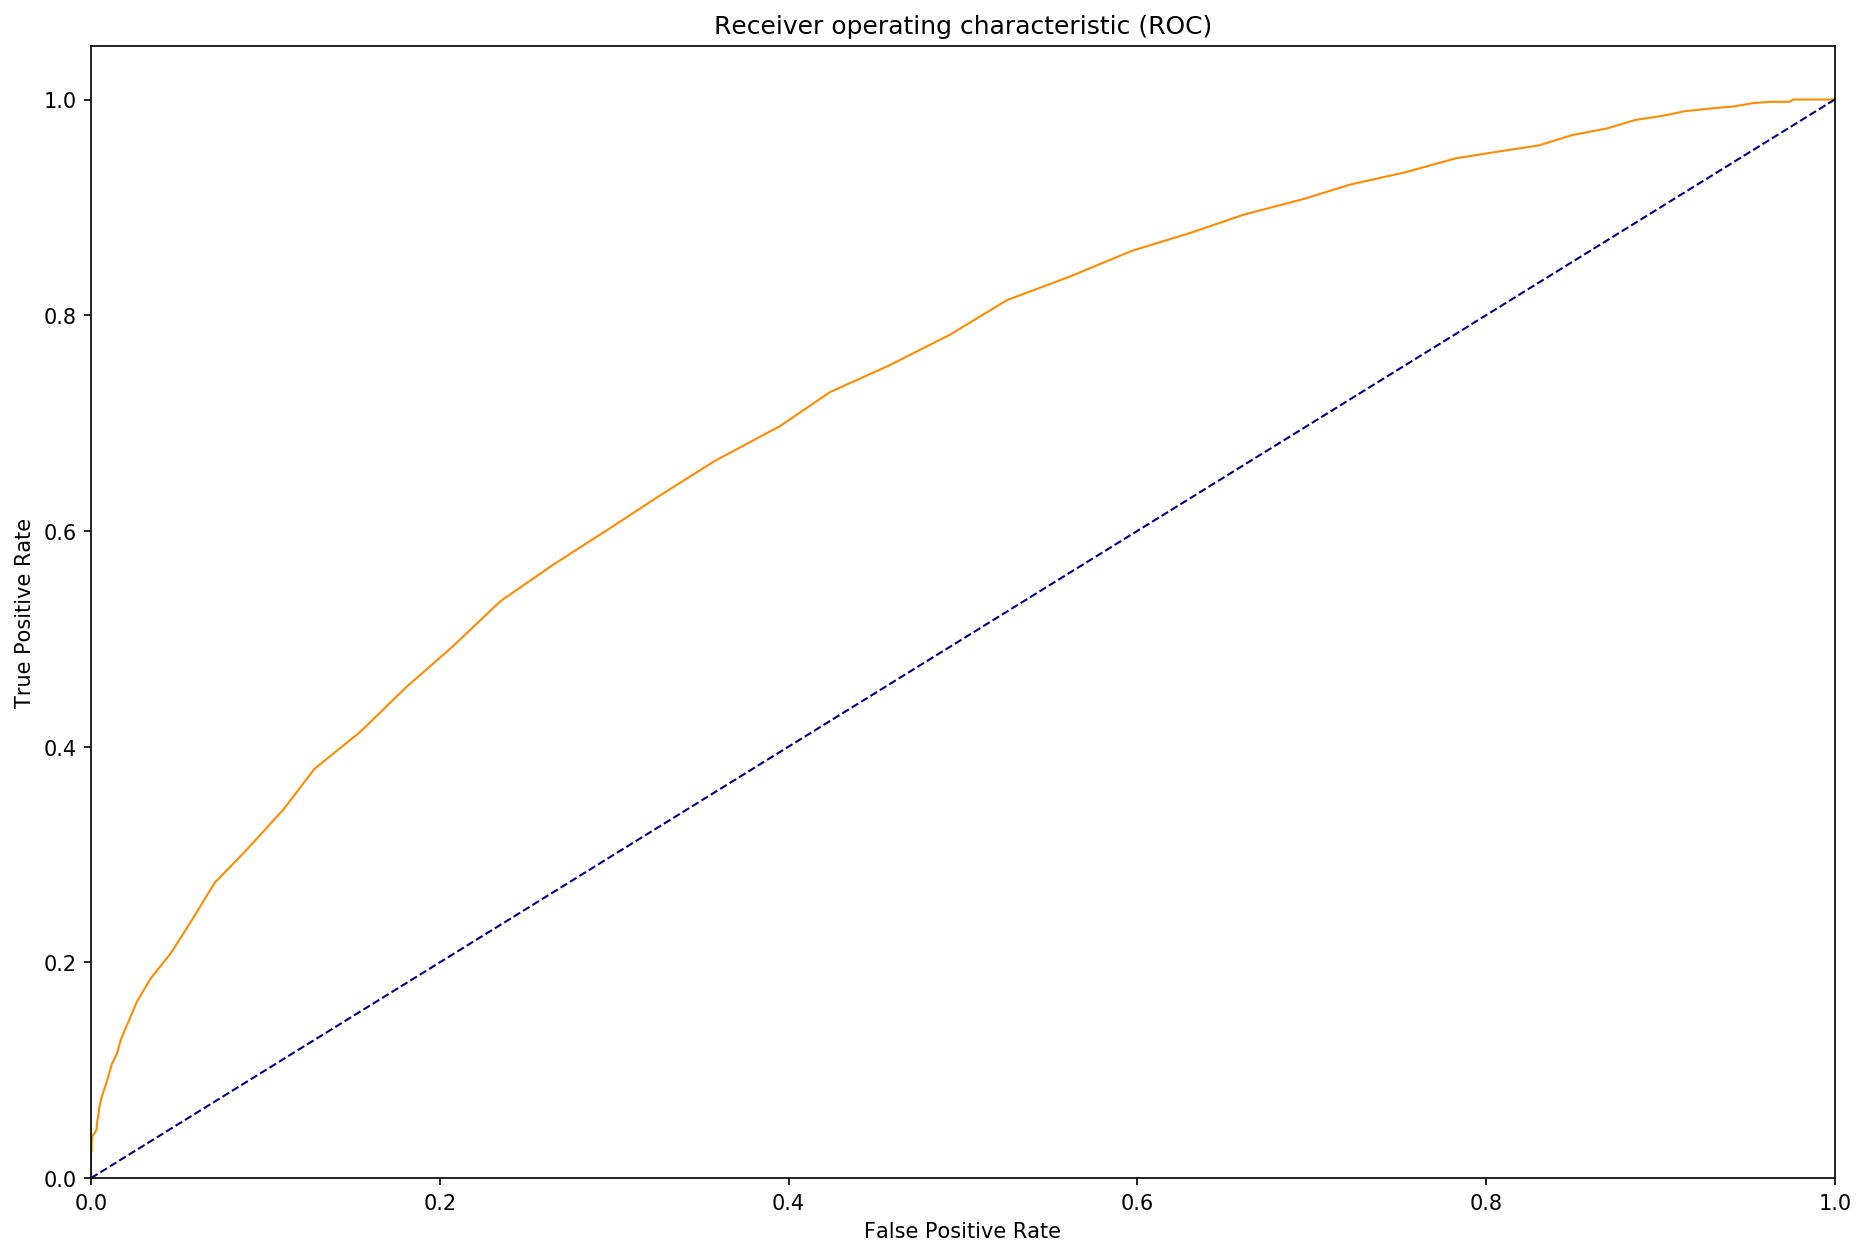

In [266]:
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

#### Debrief
Au delà du requêtage rapide possible à partir d'une base de texte pré-hachée, ce type d'approche permet également la création automatique de features de manière non-supervisée, qui dans ce cas s'appuie sur la théorie de l'information. Utilisées avec un modèle supervisé, on obtient sans effort particulier une *log loss* inférieur à 0.6 et une *AUC* supérieure à 0.7 sur sous un sous-échantillon.